### SVMs on Extended MNIST

Extend MNIST dataset by addinig a number of non-digit letters and see if the classifier can distinguish the digits from the non-digits. All non-digits will be lumped as a single 11-th class (a highly simplified version of 'detection' problem,as opposed to 'classification' problem). Detection is vital in OCR and related problems since the non useful characters must be rejected.

In addition to the concepts in the demo, you will learn:
* Combine multiple datasets
* Select the SVM parameters ( C and gamma ) via cross-validation.
* Use the GridSearchCV method to search for parameters with cross-validation

Note: Download the data from NIST website

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Download the data from the EMNIST webpage (https://www.nist.gov/itl/iad/image-group/emnist-dataset) 
Extract two files:
* emnist-digits.mat : This is a file of digits 0 to 9 , but with more examples per class
* emnist-letters.mat : This is a file of letters a/A to z/Z . The lower and upper case letters are grouped into the same class

In [3]:
# Extract the relevant fields from the MATLAB file
import scipy.io

def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)#,appendmat=True)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))
    return [Xtr, Xts, ytr, yts]

In [5]:
# Load the digit data from emnist-digits.mat
Xtr_dig, Xts_dig, ytr_dig, yts_dig =load_emnist("/Users/barrm/Documents/MATLAB/emnist-digits.mat")

240000 training samples, 40000 test samples loaded


In [6]:
# Load the letters data from emnist-letters.mat
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist("/Users/barrm/Documents/MATLAB/emnist-letters.mat")

124800 training samples, 20800 test samples loaded


In [8]:
# plot function
def plt_digit(x,y=None):

    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T, cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    if y != None:
        plt.title('%d' % y)

Plot 8 random samples from the digit training data.

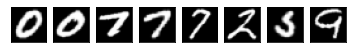

In [9]:
nsmp=8
samples=Xtr_dig[np.random.choice(Xtr_dig.shape[0], nsmp, replace=False),:]
for i in range(nsmp):
    plt.subplot(1,nsmp,i+1)
    plt_digit(samples[i,:])

Plot 8 samples from the letters training data.

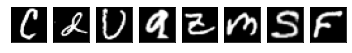

In [11]:
nsmp=8
samples=Xtr_let[np.random.choice(Xtr_let.shape[0], nsmp, replace=False),:]
for i in range(nsmp):
    plt.subplot(1,nsmp,i+1)
    plt_digit(samples[i,:])

#### Creating a Non-Digit Class

* First remove all the letters corresponding to i/I , l/L and o/O  (these letters would get confused with the digits 0 and 1) 
* Create arrays Xtr_let_rem and ytr_let_rem from the data Xtr_let and ytr_let , where the samples i with ytr_let[i] == 9, 12 or 15 are removed. Create Xts_let_rem and yts_let_rem similarly

In [12]:
remove_list = np.array([9,12,15])

# Create arrays with labels 9, 12 and 15 removed
tr_ind=np.isin(ytr_let, remove_list)
find_tr=np.array(np.where(tr_ind==True))

Xtr_let_rem, ytr_let_rem=np.delete(Xtr_let, find_tr, axis=0), np.delete(ytr_let,find_tr)
ts_ind=np.isin(yts_let, remove_list)

find_ts=np.array(np.where(ts_ind==True))
Xts_let_rem, yts_let_rem=np.delete(Xts_let, find_ts, axis=0), np.delete(yts_let,find_ts)

Create arrays Xtr1_dig and ytr1_dig by selecting 5000 random training digit samples from Xtr_dig and ytr_dig.
Create arrays Xtr1_let and ytr1_let by selecting 1000 random training letter samples from Xtr_let_rem and
ytr_let_rem . Similarly, create test arrays Xts1_dig,Xts1_let,yts1_dig,yts1_let with 5000 digits and 1000 letters.

In [13]:
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 1000
nts_dig = 5000
nts_let = 1000

dig_tr_indices=np.random.choice(Xtr_dig.shape[0], ntr_dig, replace=False)
dig_ts_indices=np.random.choice(Xts_dig.shape[0], nts_dig, replace=False)
let_tr_indices=np.random.choice(Xtr_let_rem.shape[0], ntr_let, replace=False)
let_ts_indices=np.random.choice(Xts_let_rem.shape[0], nts_let, replace=False)

# Create sub-sampled training and test data
Xtr1_dig, ytr1_dig = Xtr_dig[dig_tr_indices,:], ytr_dig[dig_tr_indices]
Xts1_dig, yts1_dig = Xts_dig[dig_ts_indices,:], yts_dig[dig_ts_indices]
Xtr1_let, ytr1_let = Xtr_let_rem[let_tr_indices,:], ytr_let_rem[let_tr_indices]
Xts1_let, yts1_let = Xts_let_rem[let_ts_indices,:], yts_let_rem[let_ts_indices]

Next, create data by combining the digit and letter arrays.
* Create an array Xtr by stacking Xtr1_dig , Xtr1_let . This should result in 6000 total samples
* Create a new label vector ytr where ytr[i] = ytr1_dig[i] for any digit sample and ytr[i]=10 for any letter sample. Thus, all the letters are lumped into a single class with label 11
* Create test arrays Xts and yts similarly

In [15]:
#Create combined letter and digit training and test data
Xtr= np.vstack((Xtr1_dig, Xtr1_let)) #np.hstack((ytr1_let, ytr1_dig))
Xts= np.vstack((Xts1_dig, Xts1_let)) #np.hstack((yts1_let, yts1_dig))
val=[10]
ytr_let_tens=val*(len(ytr1_let))
yts_let_tens=val*(len(yts1_let))
ytr=np.hstack((ytr1_dig,ytr_let_tens))
yts=np.hstack((yts1_dig,yts_let_tens))

The training data above takes values from 0 to 255. Rescale the data from -1 to 1. This will get slightly better performance on the SVM

In [16]:
# Rescale the data from -1 to 1
Xtr1 = Xtr/255.0*2 - 1
Xts1 = Xts/255.0*2 - 1

#### Run the SVM classifier

In [17]:
from sklearn import svm
# Create a classifier: a support vector classifier
svc = svm.SVC(probability=False, kernel="rbf", C=2.8, gamma=.0073, verbose=10)
#Fit the classifier on the training data.
svc.fit(Xtr1, ytr)
#Measure error on the test data
yhat=svc.predict(Xts1)
acc=np.mean(yhat== yts)
print(f'Data Accuaracy = {np.around(acc*100,4)}')

[LibSVM]Data Accuaracy = 90.7167


[[0.9507874  0.         0.         0.         0.         0.00387597
  0.00396825 0.         0.         0.         0.021     ]
 [0.         0.984375   0.         0.         0.00205339 0.00193798
  0.         0.         0.         0.         0.005     ]
 [0.00393701 0.         0.88644689 0.00403226 0.         0.
  0.         0.00988142 0.00207469 0.         0.052     ]
 [0.         0.         0.00549451 0.93145161 0.00205339 0.00968992
  0.         0.00197628 0.01037344 0.00197239 0.018     ]
 [0.         0.         0.         0.         0.90554415 0.
  0.         0.         0.         0.00394477 0.044     ]
 [0.00590551 0.         0.         0.01008065 0.         0.89147287
  0.00396825 0.         0.         0.00197239 0.045     ]
 [0.         0.00446429 0.         0.         0.         0.00193798
  0.93849206 0.         0.         0.         0.028     ]
 [0.         0.00446429 0.         0.         0.00205339 0.
  0.         0.95454545 0.00207469 0.00986193 0.014     ]
 [0.0019685  0. 

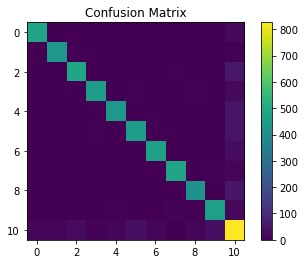

In [19]:
# Print a confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(yts,yhat)
Csum = np.sum(cm,1)
C = cm / Csum[None,:]
print(C)
plt.title('Confusion Matrix')
plt.imshow(cm)
plt.colorbar()

In [20]:
# Print the two error rates (misslabeled digits/letters)
print(f'The fraction of digits that are mislabeled as letters = {np.sum(C[0:9,10])}')
print(f'The fraction of letters that are mislabeled as digits = {np.sum(C[10,0:9])}')

The fraction of digits that are mislabeled as letters = 0.277
The fraction of letters that are mislabeled as digits = 0.2787225716641146


#### Selecting gamma and C via Cross-Validation

In the above example we used a given gamma and C value. The selection of the parameters depend on
the problem and decent performance of the SVM requires that you select these parameters carefully. The best way to select the parameters is via cross validation. Specifically, generally, one tries different values of gamma and C and selects the pair of values the lowest test error rate.
In the code below, we will try to use 3 values for C and gamma as specified in the arrays C_test and gam_test . For
each C and gamma in these arrays, fit a model on the training data and measure the accuracy on the test data. Then, print the C and gamma that result in the best accuracy.
Normally, you would try a large number of values for each of the parameters, but an SVM is very slow to train -- even with this small data set. 

In [22]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]
nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

for i in range(nC):
    for j in range(ngam):
        svc = svm.SVC(probability=False, kernel="rbf", C= C_test[i], gamma= gam_test[j],verbose=10)
        svc.fit(Xtr1, ytr)
        yhat = svc.predict(Xts1)
        acc[i,j] = np.mean(yhat == yts)

print(acc)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][[0.77683333 0.58866667 0.16666667]
 [0.86133333 0.88183333 0.20616667]
 [0.895      0.888      0.21066667]]


In [24]:
# The maximum accuracy and the corresponding best C and gamma

acc_max=acc.max()
idx_i, idx_j=np.where(acc == acc_max)
imax, jmax=np.asscalar(idx_i),np.asscalar(idx_j)
print(f'Maximum accuracy ={np.around(acc_max,4)} , corresponding best C = {C_test[imax]}, gamma = {gam_test[jmax]}')

Maximum accuracy =0.895 , corresponding best C = 10, gamma = 0.001


<ipython-input-24-b164094d7dfa>:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  imax, jmax=np.asscalar(idx_i),np.asscalar(idx_j)
